In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
import sys
sys.path.append('../../') #takes us to the directory named foreground_functions that housed the foreground_function.py 
#and the w3j.npy files

In [3]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


# parameters for generating map (dust)

In [18]:
nside = 128

A = 7.8e3 #from BICEP paper???
alpha = -0.4 #from BICEP paper
beta = 1.59 #from BICEP paper
gamma = -2.5 #chosen at random
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 10)*1.e9
input_params = [A, alpha, beta, gamma]
#create a filepath to store different power spectra
filepath = '../../power_spectra/'

# define the input model

In [9]:
%autoreload

In [10]:
start=time.time()
in_model = ff.model_dust(ells, freqs, input_params)
print(time.time()-start)

0.05207514762878418


# define the 2d data we're going to try to fit

In [19]:
##averaged 100 PS at 10 frequencies
# start=time.time()
# big_mat = np.zeros((100, len(freqs), len(ells)))
# for i in range(100):
#     if i%5 == 0:
#         print('step ' + str(i))
#     big_mat[i] = ff.ps_data_dust(ells, freqs, [A, alpha, beta, gamma])
# np.save(filepath + 'reference_ps_dust_10_freqs.npy', np.mean(big_mat, 0)) 
# print(time.time()-start)

# reference_dust = ff.ps_data_dust(ells, freqs, [A, alpha, beta, gamma])
# np.save(filepath + 'reference_ps_dust_10_freqs.npy', reference_dust) 

PS_data = np.load(filepath + 'reference_ps_dust_10_freqs.npy')

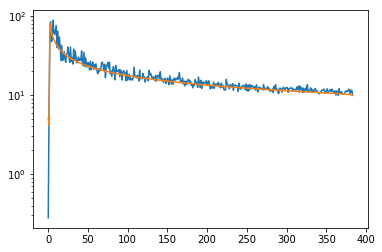

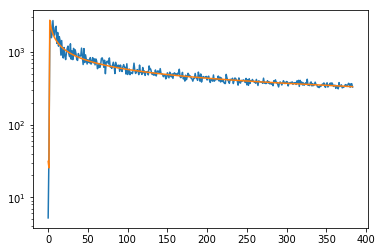

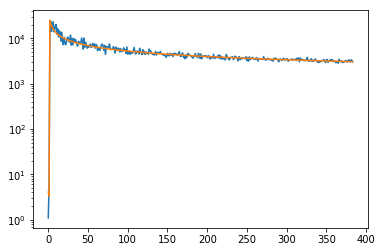

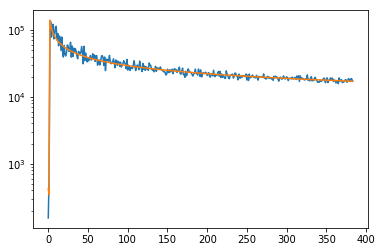

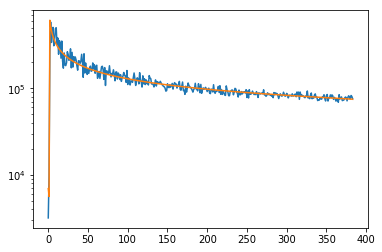

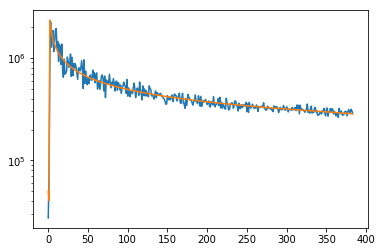

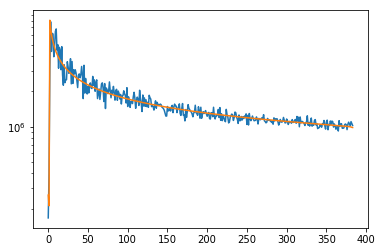

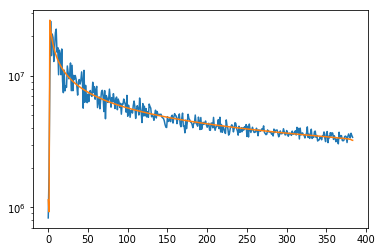

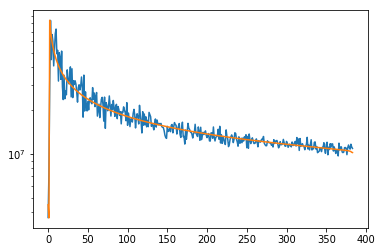

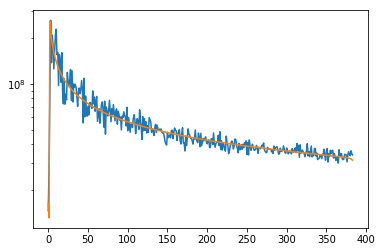

In [20]:
for i in range(len(freqs)):
    figure()
    semilogy(PS_data[i])
    semilogy(in_model[i])

# define our objective function (chi2 with cosmic variance) -- ultimately modify this for the behaviour near the high end cut off tail? Add additional uncertainty due to finite precision of the map?

In [23]:
def chi2(params, ells, freqs, data):
    chi2=0
    A, alpha, beta, gamma = params
    model = ff.model_dust(ells, freqs, params)
    
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * model**2
    
    chi2 = (data[:,30:] - model[:,30:])**2 / cosmic_var[:,30:]
    return np.sum(chi2)

In [24]:
start=time.time()
result0 = minimize(chi2, [1e3, -1,1,-2.8], args=(ells, freqs, PS_data), 
                   method='L-BFGS-B', bounds=((None, None), (None, None), (None, None), (-2.8, -2.01)))
print(time.time()-start)
print(result0)

17.337857007980347
      fun: 3677.198063430451
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        , -0.16016202, -0.09677024,  0.0649834 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 385
      nit: 65
   status: 0
  success: True
        x: array([ 7.97010066e+03, -4.11641502e-01,  1.58190355e+00, -2.29218726e+00])


In [25]:
#getting there, moving all the parameters, and it's getting the exponents basically right, it just can't get
#the amplitude right

In [27]:
x0 = result0.x
fit0 = ff.model_dust(ells, freqs, x0)
print(chi2(input_params, ells, freqs, PS_data))
print(chi2(x0, ells, freqs, PS_data))
#is there something wrong with the objective function as written?

3938.7987920549367
3677.198063430451


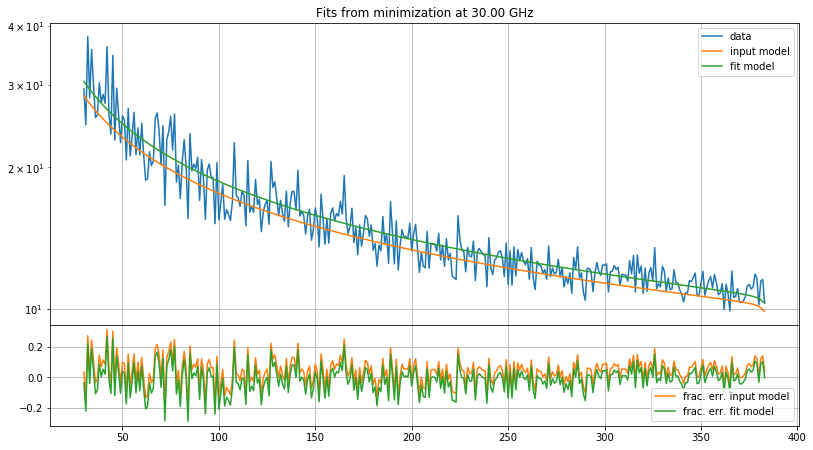

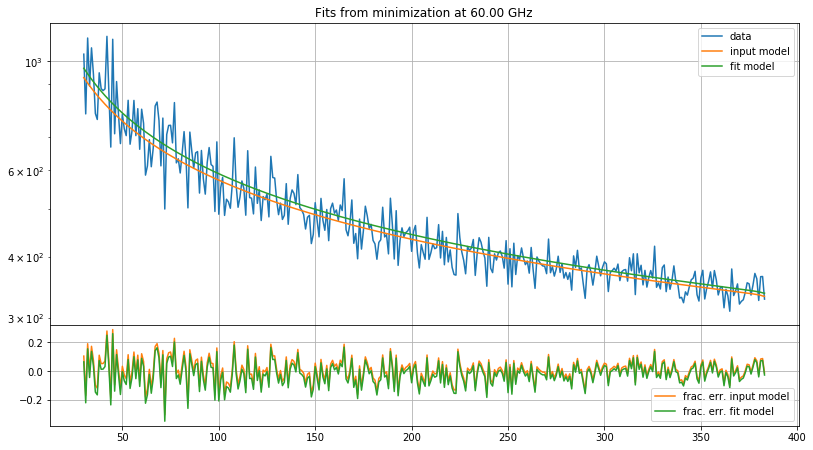

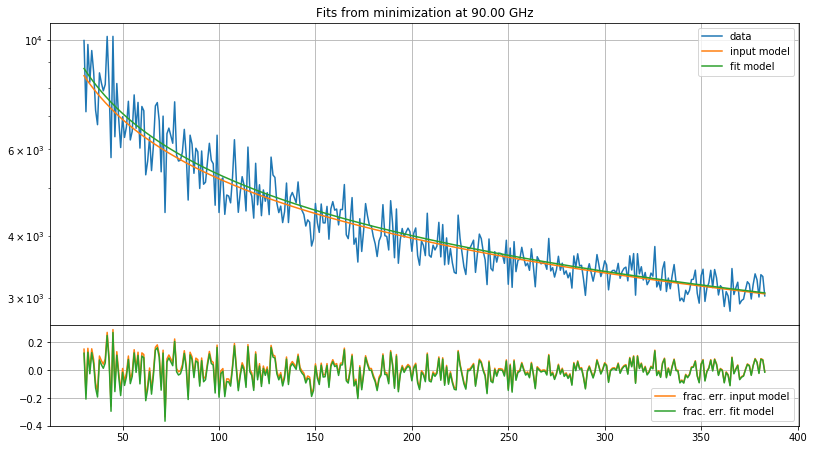

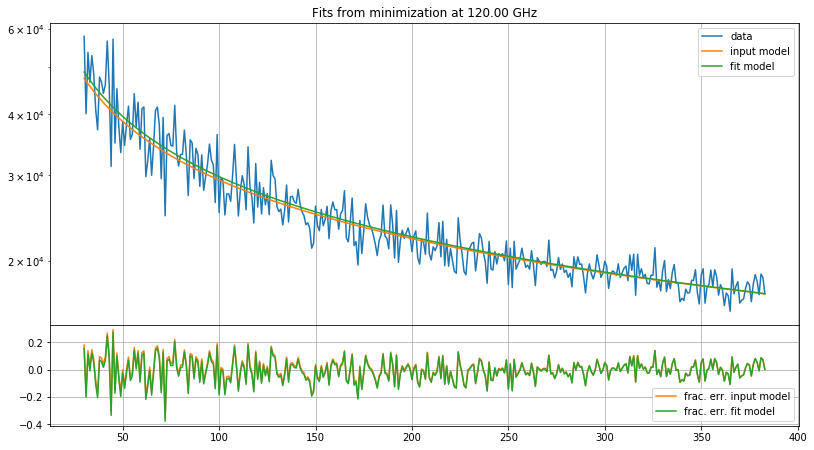

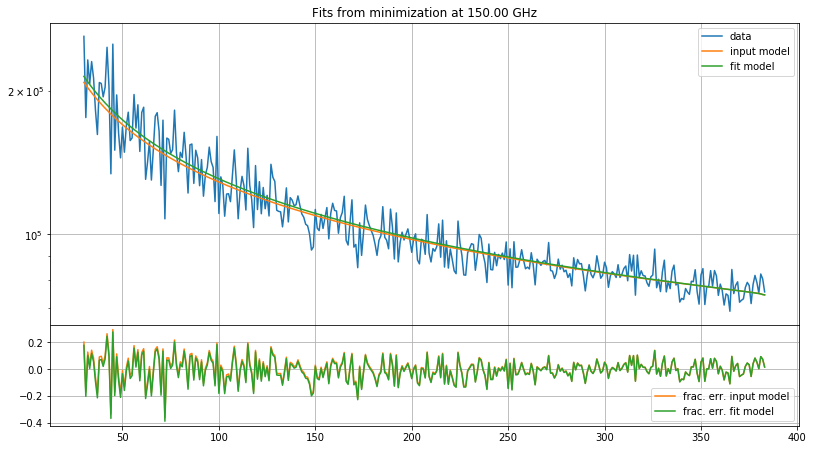

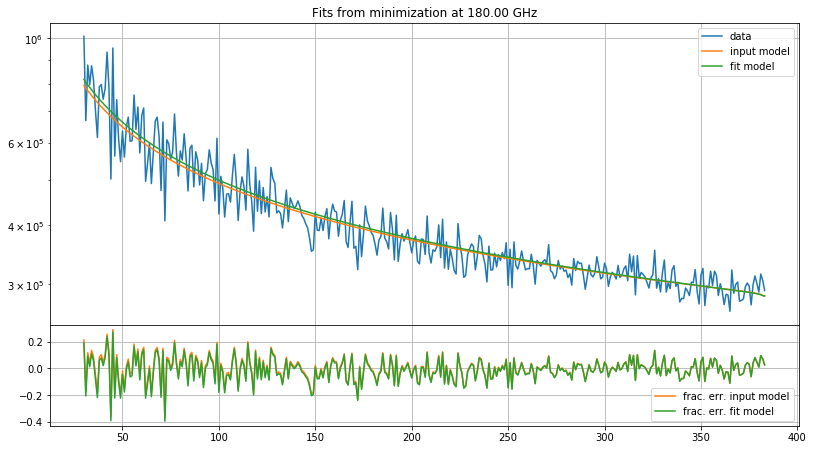

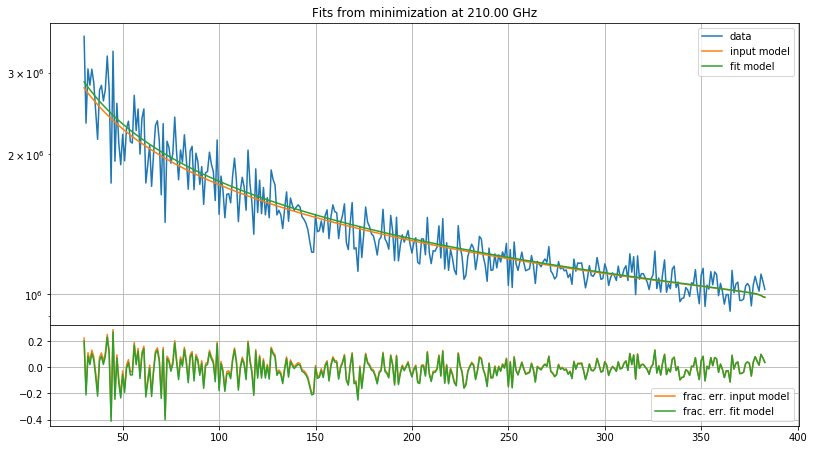

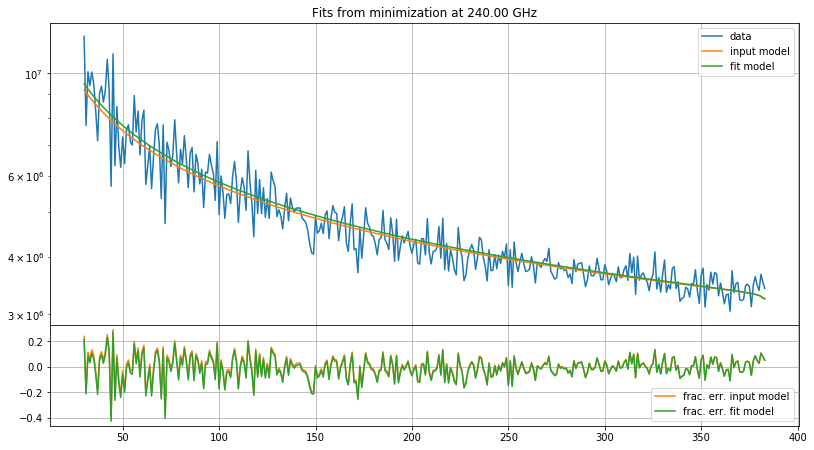

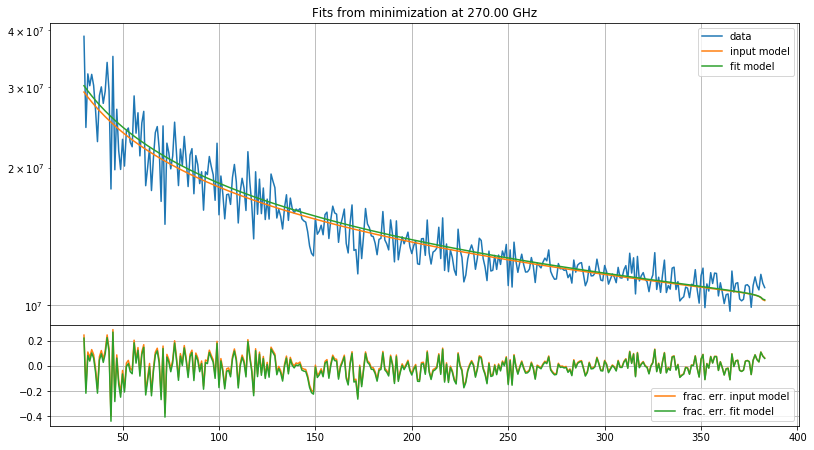

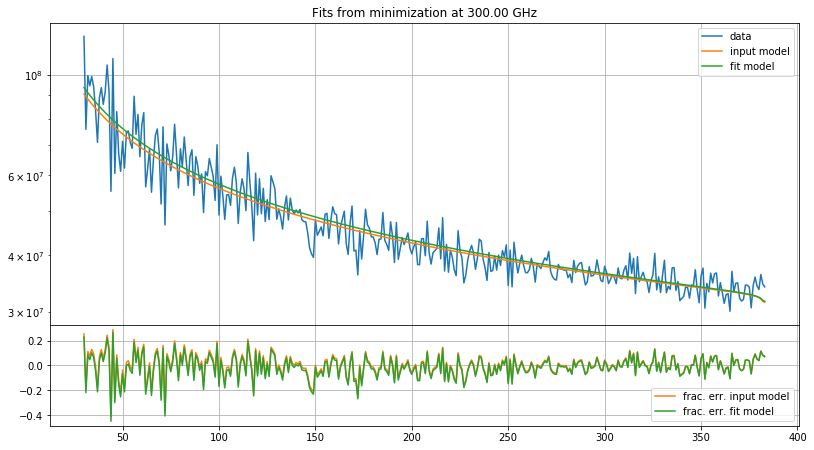

In [28]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[30:], PS_data[i][30:], label='data')
    semilogy(ells[30:], in_model[i][30:], label='input model', color='C1')
    semilogy(ells[30:], fit0[i][30:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[30:], (PS_data[i][30:]-in_model[i][30:])/PS_data[i][30:], color='C1', label='frac. err. input model')
    plot(ells[30:], (PS_data[i][30:]-fit0[i][30:])/PS_data[i][30:], color='C2', label='frac. err. fit model')
    legend()
    grid()
#     xlim(2,400)

In [29]:
print((x0-input_params)/x0*100)

[ 2.13423474  2.82806809 -0.51181705 -9.06613272]


In [ ]:
for i in range(len(freqs)):
    figure
    hist((fit0[i]-PS_data[i])/PS_data[i], bins='auto', density=True, alpha=0.7, label='fit')
    hist((in_model[i]-PS_data[i])/PS_data[i], bins='auto', density=True, alpha=0.7, label='model')
    legend()